<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.7.0


In [4]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + "images")

3995 angryimages
436 disgustimages
4097 fearimages
7215 happyimages
4965 neutralimages
4830 sadimages
3171 surpriseimages


we have relatively imbalance dataset except for the disgust class images

### Task 2: Generate Training and Validation Batches

#### By using data generators and the ImageDataGenerator class, we can efficiently load and augment images in batches during the training and evaluation processes. Data augmentation helps increase the variety and generalization of the training data by applying random transformations to the images. This can improve the model's ability to generalize and perform well on unseen data.

In [5]:
img_size = 48                              
batch_size = 64                            
datagen_train = ImageDataGenerator(horizontal_flip = True)  

train_generator = datagen_train.flow_from_directory( "train/" ,
                                                    target_size=(img_size, img_size), 
                                                    color_mode= "grayscale", 
                                                    batch_size= batch_size, 
                                                    class_mode="categorical",                          
                                                    shuffle = True) 
datagen_validation = ImageDataGenerator(horizontal_flip = True) 
validation_generator = datagen_validation.flow_from_directory( "test/",
                                                    target_size=(img_size, img_size),
                                                    color_mode= "grayscale",
                                                    batch_size= batch_size,
                                                    class_mode="categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 3: Create CNN Model

#### Defines a CNN model with convolutional, pooling, dropout, and fully connected layers. It follows a common pattern for image classification tasks. Adjust the model architecture and hyperparameters as needed for facial expression recognition

##### Applying multiple convolutional layers helps the model learn increasingly complex and abstract features as the information flows deeper into the network. The initial layers capture low-level features like edges and textures, while the deeper layers capture higher-level features such as shapes, patterns, and facial expressions.

In [6]:
model=Sequential()

#1 - conv

model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))  
model.add(BatchNormalization())  
                      
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))  
                                          
model.add(Dropout(0.25)) 

#2 -conv

model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3 - conv

model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4 - conv

model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) 

model.add(Dense(256)) 
model.add(BatchNormalization()) 
model.add(Activation('relu')) 
model.add(Dropout(0.25)) 

model.add(Dense(7, activation='softmax'))


opt=Adam(learning_rate=0.0005) 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary() #displays a summary of the model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

Total params: 2,735,751
Trainable params: 2,733,575 (this will be updated during traing)
Non-trainable params: 2,176 (this will not be updated during training)

### Task 4: Train and Evaluate Model

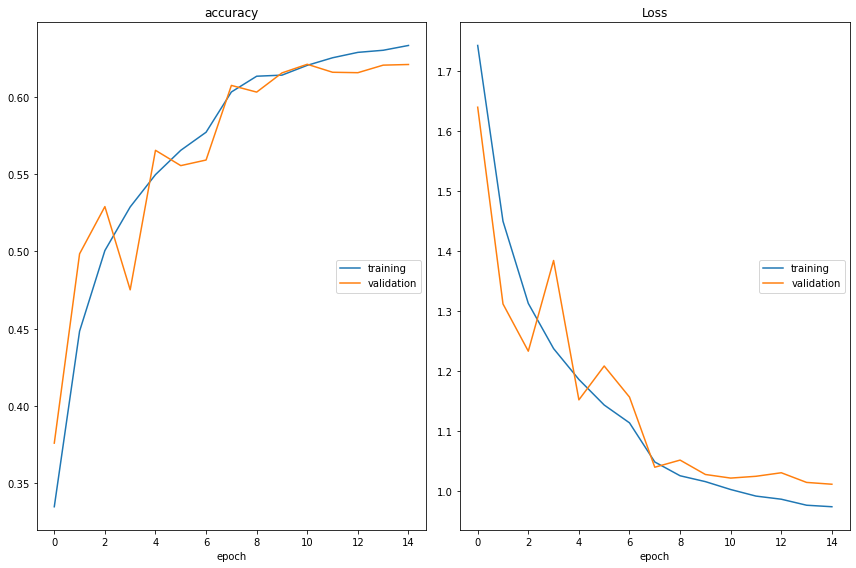

accuracy
	training         	 (min:    0.335, max:    0.633, cur:    0.633)
	validation       	 (min:    0.376, max:    0.621, cur:    0.621)
Loss
	training         	 (min:    0.974, max:    1.743, cur:    0.974)
	validation       	 (min:    1.011, max:    1.640, cur:    1.011)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 1495s 3s/step - loss: 0.9740 - accuracy: 0.6333 - val_loss: 1.0115 - val_accuracy: 0.6210 - lr: 5.0000e-06


In [7]:
epochs=15 
steps_per_epoch= train_generator.n//train_generator.batch_size 
validation_steps= validation_generator.n//validation_generator.batch_size 

checkpoint=ModelCheckpoint("model_weights.h5", monitor="val_accuracy",
                            save_weights_only=True, mode='max', verbose=1)

reduce_learning_rate= ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_learning_rate=0.00001, model='auto')


callbacks = [PlotLossesCallback(), checkpoint, reduce_learning_rate]


history = model.fit(x=train_generator,steps_per_epoch= steps_per_epoch,epochs=epochs,validation_data=validation_generator,validation_steps=validation_steps,callbacks=callbacks)
 

#### the training accuracy is 63.33% (0.633) and the validation accuracy is 62.10% (0.621).
#### the training and validation accuracy values are 63.33% and 62.10% respectively, which are relatively close. 
#### This indicates that the model is performing similarly on both the training and validation data.
#### lower loss values indicate better performance
#### the training loss is 0.974 and the validation loss is 1.011. Comparing these values, we can see that the training loss is 
#### lower than the validation loss, 
#### which suggests that the model is performing relatively better on the training data compared to the validation data.

### Task 5: Represent Model as JSON String

#### Saves the model architecture (in JSON format) to a file named "model.json"

In [9]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)